In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import os

WS = "/content/drive/My Drive/reds"
os.chdir(WS)

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();


from utils import get_data, split, oversample, get_cross_val_data, normalise

### Récupération des données


In [ ]:
RANDOM_SEED = 42

df = get_data()
train_df, test_df = split(df, n_user_test=2, seed = RANDOM_SEED)

/content/drive/My Drive/reds/utils.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  data = h5py.File(addr)


In [ ]:
train_df['user'].nunique(), test_df['user'].nunique()

(6, 2)

### 1. Baseline

In [ ]:
X_train = train_df.drop(["user","target"],axis = 1)
Y_train = train_df.iloc[:,1]
tmp = oversample(test_df)
X_test = tmp.drop(["user","target"],axis = 1)
Y_test =  tmp.iloc[:,1]

### Modèle sur une seule variable

In [ ]:
train_df.columns

Index(['user', 'target', 'sensor_0', 'sensor_1', 'sensor_2', 'sensor_3',
       'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28'],
      dtype='object')

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.base import clone

### Modèle simple

In [ ]:
simple_models = {
    "SVM_linear_C0.01" : SVC(kernel="linear", C=0.01),
    "SVM_linear_C0.025" : SVC(kernel="linear", C=0.025),
    "SVM_linear_C0.05" : SVC(kernel="linear", C=0.05),
    "SVM_linear_C0.001" : SVC(kernel="linear", C=0.01),
     "SCM_poly_2" : SVC(kernel = 'poly', degree = 2, C=0.05),
    "SVM Gaussian_g2_c1" :  SVC(gamma=2, C=1),
    "SVM Gaussian_g2_c001" :  SVC(gamma=2, C=0.01),
    #"GaussianProcess" : GaussianProcessClassifier(1.0 * RBF(1.0)),
    "Gaussian NB" :  GaussianNB(),
    "DT_10" : DecisionTreeClassifier(random_state=0, max_depth=10),
    "DT_5" : DecisionTreeClassifier(random_state=0, max_depth=5),
    "DT_3" : DecisionTreeClassifier(random_state=0, max_depth=3),
    "SGD_5" : SGDClassifier(alpha=1e-5),
    "Knn_3" : KNeighborsClassifier(n_neighbors=3),
    "Knn_5" : KNeighborsClassifier(n_neighbors=5),
    "Knn_10" : KNeighborsClassifier(n_neighbors=10),
    "Logreg_1e5" : LogisticRegression(max_iter=3000, C=1e5),
    "Logreg_1e3" : LogisticRegression(max_iter=3000, C=1e3),
    "Logreg_1e1" : LogisticRegression(max_iter=3000, C=1e1)
}


In [ ]:
simple_models.keys()

dict_keys(['SVM_linear_C0.01', 'SVM_linear_C0.025', 'SVM_linear_C0.05', 'SVM_linear_C0.001', 'SCM_poly_2', 'SVM Gaussian_g2_c1', 'SVM Gaussian_g2_c001', 'Gaussian NB', 'DT_10', 'DT_5', 'DT_3', 'SGD_5', 'Knn_3', 'Knn_5', 'Knn_10', 'Logreg_1e5', 'Logreg_1e3', 'Logreg_1e1'])

### Sans oversampling

In [ ]:
acc_df, time_df = pool(simple_models, train_df, oversample_train=False)
acc_df

,SVM_linear_C0.05,SVM_linear_C0.025,SVM_linear_C0.01,SVM_linear_C0.001,Logreg_1e1,Knn_3,Gaussian NB,Knn_5,Knn_10,DT_10,SGD_5,Logreg_1e3,Logreg_1e5,DT_5,SCM_poly_2,DT_3,SVM Gaussian_g2_c1,SVM Gaussian_g2_c001
mean_train_accuracy,0.9679,0.9510,0.9353,0.9353,0.9977,0.9638,0.9315,0.9531,0.9203,0.9906,0.9666,1.0000,1.0000,0.7272,0.7072,0.3182,0.9994,0.9397
std_train_accuracy,0.0086,0.0101,0.0126,0.0126,0.0011,0.0114,0.0183,0.0124,0.0147,0.0043,0.0127,0.0000,0.0000,0.0198,0.0207,0.0116,0.0003,0.0314
mean_val_accuracy,0.8704,0.8651,0.8484,0.8484,0.8032,0.8010,0.8004,0.7952,0.7722,0.7650,0.7649,0.7378,0.7111,0.6302,0.5202,0.2932,0.0417,0.0417
std_val_accuracy,0.1128,0.1377,0.1292,0.1292,0.1074,0.1362,0.1685,0.1256,0.1232,0.0957,0.1139,0.1012,0.0908,0.0571,0.0649,0.0371,0.0000,0.0000
training_time,0.0500,0.0600,0.0700,0.0700,0.9900,0.0000,0.0000,0.0000,0.0000,0.0200,0.1000,2.5300,1.7700,0.0200,0.1700,0.0100,0.3400,0.3000
prediction_time,0.0200,0.0200,0.0200,0.0200,0.0000,0.0300,0.0000,0.0300,0.0300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0200,0.0000,0.0400,0.0400


In [ ]:
print("Val accuracy de svm linear_C0.025 = ", acc_df.loc["mean_val_accuracy", 'SVM_linear_C0.025'])

Val accuracy de svm linear_C0.025 =  0.8651


### Avec oversampling

In [ ]:
acc_df, time_df = pool(simple_models, train_df, oversample_train=True)
stats = pd.concat([acc_df, time_df], axis=0)
stats.T.sort_values(by="mean_val_accuracy", ascending=False).T

,SVM_linear_C0.025,SVM_linear_C0.01,SVM_linear_C0.001,SVM_linear_C0.05,Gaussian NB,Knn_3,Logreg_1e1,Knn_10,Knn_5,DT_10,SGD_5,Logreg_1e3,Logreg_1e5,DT_5,SCM_poly_2,DT_3,SVM Gaussian_g2_c001,SVM Gaussian_g2_c1
mean_train_accuracy,0.9761,0.9629,0.9629,0.9834,0.9470,0.9856,0.9989,0.9593,0.9791,0.9950,0.9810,1.0000,1.0000,0.7482,0.6889,0.3299,0.0451,0.9997
std_train_accuracy,0.0035,0.0020,0.0020,0.0038,0.0109,0.0052,0.0005,0.0053,0.0054,0.0035,0.0056,0.0000,0.0000,0.0028,0.0491,0.0161,0.0005,0.0001
mean_val_accuracy,0.8637,0.8573,0.8573,0.8495,0.8072,0.8017,0.8013,0.7963,0.7948,0.7662,0.7562,0.7416,0.7163,0.6598,0.5370,0.3095,0.0417,0.0417
std_val_accuracy,0.1155,0.1323,0.1323,0.1209,0.1767,0.1524,0.1150,0.1353,0.1495,0.1135,0.1351,0.1174,0.1027,0.0851,0.1254,0.0149,0.0000,0.0000
training_time,0.1200,0.1600,0.1600,0.1100,0.0000,0.0100,2.4700,0.0100,0.0100,0.0400,0.1800,6.6300,3.8900,0.0300,0.5800,0.0200,1.2100,0.7300
prediction_time,0.0300,0.0400,0.0400,0.0200,0.0000,0.0400,0.0000,0.0500,0.0500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0500,0.0000,0.0700,0.0400
training_time,0.1200,0.1600,0.1600,0.1100,0.0000,0.0100,2.4700,0.0100,0.0100,0.0400,0.1800,6.6300,3.8900,0.0300,0.5800,0.0200,1.2100,0.7300
prediction_time,0.0300,0.0400,0.0400,0.0200,0.0000,0.0400,0.0000,0.0500,0.0500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0500,0.0000,0.0700,0.0400


In [ ]:
# Ensemble
simple_models = {
    "SVM_linear_C0.01" : SVC(kernel="linear", C=0.01),
    "SVM_linear_C0.025" : SVC(kernel="linear", C=0.025),
    "SVM_linear_C0.05" : SVC(kernel="linear", C=0.05),
    "SVM_linear_C0.001" : SVC(kernel="linear", C=0.01),
     "SCM_poly_2" : SVC(kernel = 'poly', degree = 2, C=0.05),
    "SVM Gaussian_g2_c001" :  SVC(gamma=2, C=0.01),
    "Gaussian NB" :  GaussianNB(),
    "DT_10" : DecisionTreeClassifier(random_state=0, max_depth=10),
    "DT_5" : DecisionTreeClassifier(random_state=0, max_depth=5),
    "DT_3" : DecisionTreeClassifier(random_state=0, max_depth=3),
    "SGD_5" : SGDClassifier(alpha=1e-5),
    "Knn_3" : KNeighborsClassifier(n_neighbors=3),
    "Knn_10" : KNeighborsClassifier(n_neighbors=10),
    "Logreg_1e5" : LogisticRegression(max_iter=3000, C=1e5),
    "Logreg_1e3" : LogisticRegression(max_iter=3000, C=1e3),
    "Logreg_1e1" : LogisticRegression(max_iter=3000, C=1e1)
}


ensemble_models = {

    "Random Forest 100" : RandomForestClassifier(n_estimators=100, random_state=0),
    "Random Forest 200" : RandomForestClassifier(n_estimators=200, random_state=0),
    "Random Forest 500" : RandomForestClassifier(n_estimators=500, random_state=0),
    "Random Forest 1000" : RandomForestClassifier(n_estimators=1000, random_state=0),

    "Extra trees 100" : ExtraTreesClassifier(n_estimators=100, random_state=0),
    "Extra trees 200" : ExtraTreesClassifier(n_estimators=200, random_state=0),
    "Extra trees 300" : ExtraTreesClassifier(n_estimators=300, random_state=0),
    "Extra trees 500" : ExtraTreesClassifier(n_estimators=500, random_state=0),
    "Extra trees 1000" : ExtraTreesClassifier(n_estimators=1000, random_state=0)

}

n_estimators_list = [10, 20, 30]
for n_estimators in n_estimators_list:
    for name, model in simple_models.items():
        ensemble_models[f"Bagging of {n_estimators} {name}"] = BaggingClassifier(model, n_estimators=n_estimators)

In [ ]:
ensemble_models.keys()

dict_keys(['Random Forest 100', 'Random Forest 200', 'Random Forest 500', 'Random Forest 1000', 'Extra trees 100', 'Extra trees 200', 'Extra trees 300', 'Extra trees 500', 'Extra trees 1000', 'Bagging of 10 SVM_linear_C0.01', 'Bagging of 10 SVM_linear_C0.025', 'Bagging of 10 SVM_linear_C0.05', 'Bagging of 10 SVM_linear_C0.001', 'Bagging of 10 SCM_poly_2', 'Bagging of 10 SVM Gaussian_g2_c001', 'Bagging of 10 Gaussian NB', 'Bagging of 10 DT_10', 'Bagging of 10 DT_5', 'Bagging of 10 DT_3', 'Bagging of 10 SGD_5', 'Bagging of 10 Knn_3', 'Bagging of 10 Knn_10', 'Bagging of 10 Logreg_1e5', 'Bagging of 10 Logreg_1e3', 'Bagging of 10 Logreg_1e1', 'Bagging of 20 SVM_linear_C0.01', 'Bagging of 20 SVM_linear_C0.025', 'Bagging of 20 SVM_linear_C0.05', 'Bagging of 20 SVM_linear_C0.001', 'Bagging of 20 SCM_poly_2', 'Bagging of 20 SVM Gaussian_g2_c001', 'Bagging of 20 Gaussian NB', 'Bagging of 20 DT_10', 'Bagging of 20 DT_5', 'Bagging of 20 DT_3', 'Bagging of 20 SGD_5', 'Bagging of 20 Knn_3', 'Bagging

In [ ]:
acc_df, time_df = pool(ensemble_models, train_df, oversample_train=False)
acc_df

,Extra trees 300,Extra trees 1000,Extra trees 500,Random Forest 200,Random Forest 500,Extra trees 200,Random Forest 1000,Random Forest 100,Extra trees 100,Bagging of 20 SVM_linear_C0.05,Bagging of 10 SVM_linear_C0.05,Bagging of 30 SVM_linear_C0.05,Bagging of 30 SVM_linear_C0.025,Bagging of 10 SVM_linear_C0.025,Bagging of 20 SVM_linear_C0.025,Bagging of 30 DT_10,Bagging of 30 SVM_linear_C0.001,Bagging of 30 SVM_linear_C0.01,Bagging of 10 SVM_linear_C0.001,Bagging of 10 SVM_linear_C0.01,Bagging of 20 DT_10,Bagging of 20 SVM_linear_C0.01,Bagging of 20 SVM_linear_C0.001,Bagging of 30 Logreg_1e1,Bagging of 10 DT_10,Bagging of 20 Logreg_1e1,Bagging of 10 Logreg_1e1,Bagging of 20 Logreg_1e3,Bagging of 30 Logreg_1e3,Bagging of 20 Logreg_1e5,Bagging of 10 Logreg_1e5,Bagging of 30 Logreg_1e5,Bagging of 10 Logreg_1e3,Bagging of 30 SGD_5,Bagging of 20 SGD_5,Bagging of 20 Knn_3,Bagging of 30 Knn_3,Bagging of 30 Knn_10,Bagging of 20 Gaussian NB,Bagging of 20 DT_5,Bagging of 30 DT_5,Bagging of 30 Gaussian NB,Bagging of 10 Knn_3,Bagging of 10 SGD_5,Bagging of 10 Gaussian NB,Bagging of 20 Knn_10,Bagging of 10 DT_5,Bagging of 10 Knn_10,Bagging of 30 DT_3,Bagging of 20 DT_3,Bagging of 10 DT_3,Bagging of 30 SCM_poly_2,Bagging of 20 SCM_poly_2,Bagging of 10 SCM_poly_2,Bagging of 30 SVM Gaussian_g2_c001,Bagging of 10 SVM Gaussian_g2_c001,Bagging of 20 SVM Gaussian_g2_c001
mean_train_accuracy,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.9742,0.9711,0.9739,0.9548,0.9546,0.9567,0.9999,0.9349,0.9349,0.9343,0.9343,0.9992,0.9380,0.9380,0.9961,0.9975,0.9955,0.9947,0.9988,0.9996,0.9991,0.9979,0.9996,0.9978,0.9808,0.9789,0.9756,0.9777,0.9403,0.9355,0.9037,0.9047,0.9347,0.9722,0.9753,0.9318,0.9377,0.8946,0.9320,0.7033,0.6618,0.6160,0.5786,0.5164,0.4592,0.0417,0.0417,0.0417
std_train_accuracy,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0058,0.0063,0.0065,0.0097,0.0112,0.0103,0.0002,0.0136,0.0136,0.0144,0.0144,0.0006,0.0108,0.0108,0.0007,0.0014,0.0018,0.0021,0.0007,0.0005,0.0007,0.0007,0.0007,0.0009,0.0064,0.0069,0.0069,0.0065,0.0131,0.0173,0.0240,0.0227,0.0174,0.0081,0.0079,0.0212,0.0135,0.0243,0.0119,0.0352,0.0573,0.0546,0.0695,0.0303,0.0346,0.0000,0.0000,0.0000
mean_val_accuracy,0.9141,0.9119,0.9106,0.9096,0.9091,0.9079,0.9077,0.9029,0.9010,0.8710,0.8708,0.8691,0.8654,0.8647,0.8611,0.8525,0.8491,0.8491,0.8431,0.8431,0.8424,0.8418,0.8418,0.8414,0.8374,0.8365,0.8340,0.8308,0.8270,0.8239,0.8214,0.8205,0.8165,0.8157,0.8152,0.8110,0.8077,0.8029,0.8028,0.8013,0.8010,0.7975,0.7959,0.7933,0.7926,0.7872,0.7829,0.7817,0.6420,0.5874,0.5383,0.4066,0.3500,0.3034,0.0417,0.0417,0.0417
std_val_accuracy,0.0591,0.0575,0.0576,0.0665,0.0671,0.0558,0.0680,0.0686,0.0548,0.1197,0.1198,0.1238,0.1327,0.1250,0.1271,0.1077,0.1300,0.1300,0.1274,0.1274,0.1063,0.1273,0.1273,0.1231,0.1049,0.1143,0.1172,0.1179,0.1207,0.1150,0.1178,0.1174,0.1194,0.1194,0.1166,0.1273,0.1316,0.1300,0.1644,0.0876,0.0828,0.1642,0.1305,0.1127,0.1577,0.1198,0.0776,0.1204,0.0816,0.1112,0.0972,0.0878,0.0640,0.0295,0.0000,0.0000,0.0000
training_time,0.7200,2.4100,1.2100,1.0000,2.5100,0.4800,5.0100,0.5100,0.2400,0.6700,0.3200,0.9500,1.1200,0.3300,0.7200,0.5200,1.1300,1.1400,0.3800,0.3800,0.3500,0.7600,0.7600,28.8400,0.1700,19.4400,9.7200,34.9000,52.7700,20.4900,10.5700,30.5100,17.8700,2.1700,1.4200,0.1000,0.1500,0.1400,0.0900,0.2600,0.3900,0.1300,0.0500,0.7400,0.0400,0.0900,0.1300,0.0500,0.2600,0.1700,0.0900,2.3300,1.5300,0.7700,3.9300,1.3200,2.6300
prediction_time,0.0500,0.1500,0.0800,0.0300,0.0700,0.0300,0.1600,0.0100,0.0200,0.2500,0.1200,0.3400,0.3900,0.1200,0.2800,0.0100,0.4100,0.4100,0.1400,0.1400,0.0000,0.2800,0.2800,0.0200,0.0000,0.0100,0.0100,0.0100,0.0200,0.0100,0.0100,0.0200,0.0100,0.0200,0.0100,0.4300,0.6400,0.6700,0.0400,0.0000,0.0100,0.0500,0.2100,0.0100,0.0200,0.4500,0.0000,0.2300,0.0000,0.0000,0.0000,0.4700,0.3200,0.1600,0.6900,0.2300,0.4700


In [ ]:
ensemble_models = {

    "Random Forest 100" : RandomForestClassifier(n_estimators=100, random_state=0),
    "Random Forest 200" : RandomForestClassifier(n_estimators=200, random_state=0),
    "Random Forest 500" : RandomForestClassifier(n_estimators=500, random_state=0),
    "Random Forest 1000" : RandomForestClassifier(n_estimators=1000, random_state=0),

    "Extra trees 100" : ExtraTreesClassifier(n_estimators=100, random_state=0),
    "Extra trees 200" : ExtraTreesClassifier(n_estimators=200, random_state=0),
    "Extra trees 300" : ExtraTreesClassifier(n_estimators=300, random_state=0),
    "Extra trees 500" : ExtraTreesClassifier(n_estimators=500, random_state=0),
    "Extra trees 1000" : ExtraTreesClassifier(n_estimators=1000, random_state=0)

}
acc_df, time_df = pool(ensemble_models, train_df, oversample_train=True)
acc_df

,Extra trees 500,Extra trees 1000,Extra trees 300,Extra trees 200,Random Forest 500,Random Forest 1000,Extra trees 100,Random Forest 200,Random Forest 100
mean_train_accuracy,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
std_train_accuracy,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
mean_val_accuracy,0.9121,0.9105,0.9099,0.9091,0.9052,0.9050,0.9043,0.9028,0.9018
std_val_accuracy,0.0595,0.0614,0.0577,0.0567,0.0725,0.0712,0.0611,0.0725,0.0718
training_time,1.6000,3.1900,0.9600,0.6300,3.6800,7.3600,0.3100,1.8200,0.7300
prediction_time,0.0800,0.1500,0.0500,0.0300,0.0700,0.1400,0.0200,0.0400,0.0200


### Analyse du meilleur modèle

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [ ]:
#oversample(df_te)

In [ ]:
%time
x_train, x_test = normalise(X_train.values, X_test.values)
model = ExtraTreesClassifier(n_estimators=300, random_state=0)
model.fit(x_train, Y_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=300,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

In [ ]:
print("Score on train : ", model.score(x_train, Y_train))
print("Score on test : ", model.score(x_test, Y_test))

Score on train :  1.0
Score on test :  0.9458333333333333


In [ ]:
y_test_pred = model.predict(x_test)
conf = confusion_matrix(Y_test, y_test_pred, normalize="pred")

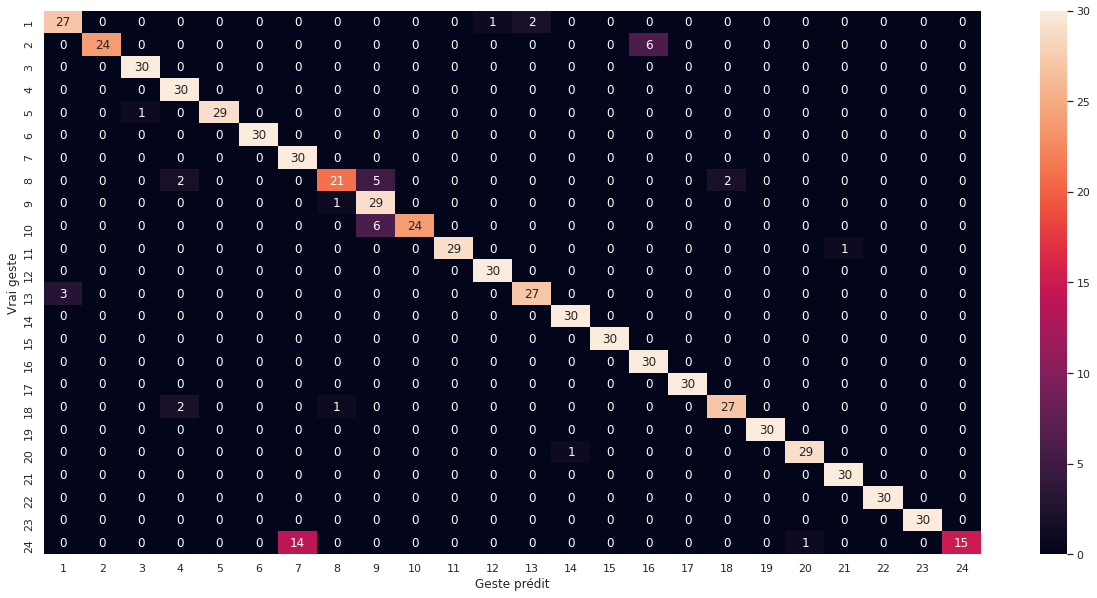

In [ ]:
data = {'Vrai geste':    Y_test.values.flatten(),
        'Geste prédit': y_test_pred.flatten()
        }

df = pd.DataFrame(data, columns=['Vrai geste','Geste prédit'])
confusion_matrix = pd.crosstab(df['Vrai geste'], df['Geste prédit'], rownames=['Vrai geste'], colnames=['Geste prédit'])#, margins = True)
plt.figure(figsize=(21, 10))
sns.heatmap(confusion_matrix, annot=True)
plt.savefig("conf_matrix.png")
plt.show()

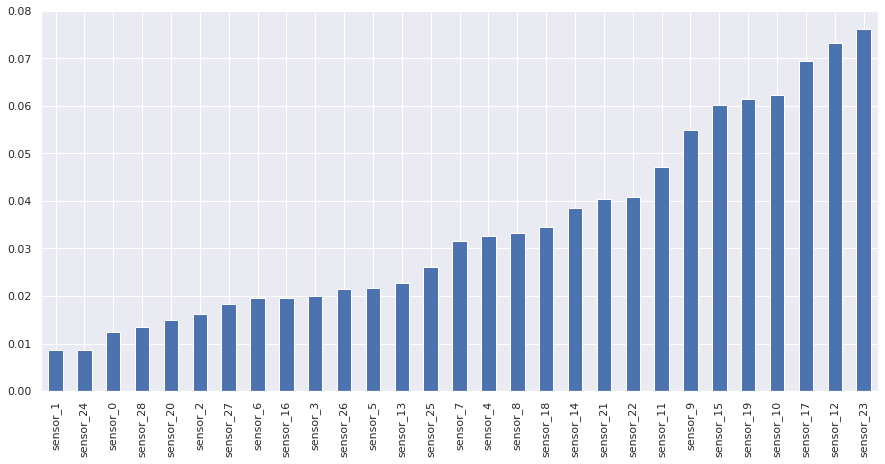

In [ ]:
plt.figure(figsize=(15, 7))
feat_imp = pd.Series(model.feature_importances_, X_train.columns).sort_values()
feat_imp.plot(kind="bar")
plt.savefig("feat_imp.png")
plt.show()

In [ ]:
%time

ind = model.feature_importances_.argsort()[:29]
clf = OnSubsetWrapper(ExtraTreesClassifier(n_estimators=300, random_state=0), ind )
clf.fit(x_train, Y_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.25 µs


In [ ]:
print("Score on train : ", clf.score(x_train, Y_train))
print("Score on test : ", clf.score(x_test, Y_test))

Score on train :  1.0
Score on test :  0.9375


### PCA subset selection

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def pca_transform(x_train, x_val, n_components = 1):
    pca = PCA(n_components = n_components)
    pca.fit(x_train)
    return pca.transform(x_train), pca.transform(x_val)

In [ ]:
best_simple_models = {
    "SVM_linear_C0.01" : SVC(kernel="linear", C=0.01),
    "SVM_linear_C0.025" : SVC(kernel="linear", C=0.025),
    "SVM_linear_C0.05" : SVC(kernel="linear", C=0.05),
    "SVM_linear_C0.001" : SVC(kernel="linear", C=0.01),
    "Gaussian NB" :  GaussianNB()#,
    
    #"DT_10" : DecisionTreeClassifier(random_state=0, max_depth=10),
    #"DT_5" : DecisionTreeClassifier(random_state=0, max_depth=5),
    #"SGD_5" : SGDClassifier(alpha=1e-5),
    #"Knn_3" : KNeighborsClassifier(n_neighbors=3),
    #"Knn_5" : KNeighborsClassifier(n_neighbors=5),
    #"Knn_10" : KNeighborsClassifier(n_neighbors=10),
    #"Logreg_1e5" : LogisticRegression(max_iter=3000, C=1e5),
    #"Logreg_1e3" : LogisticRegression(max_iter=3000, C=1e3),
    #"Logreg_1e1" : LogisticRegression(max_iter=3000, C=1e1)
}

In [ ]:
stats = pd.DataFrame()
for n_components in range(train_df.shape[0] - 2):
    pca_tr = lambda x : pca_transform(x[0], x[1], n_components)
    acc_df, time_df = pool(ensemble_models, train_df, oversample_train=False, transforms = pca_tr)
    acc_df.columns = pd.Index([x+f"_pca{n_components}" for x in acc_df.columns])
    stats = pd.concat((stats, acc_df), axis=1)